# Question 2: Training Model

In [1]:
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as data
from models.attention import MultiHeadAttention
from models.embedder import Embedder, FeedForward, Norm, PositionalEncoder, get_clones
from transformers import GPT2Tokenizer

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Decoder

In [3]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.norm_2 = Norm(d_model)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

In [4]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, trg, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x, trg_mask)
        return self.norm(x)

## Transformer

In [5]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout, device):
        super().__init__()
        self.device = device
        self.vocab_size = vocab_size
        self.decoder = Decoder(vocab_size, d_model, N, heads, dropout)

    def forward(self, trg, trg_mask):
        d_output = self.decoder(trg, trg_mask)
        output = torch.matmul(d_output, self.decoder.embed.embed.weight.t())
        return output

## No-Peak Mask

In [6]:
def nopeak_mask(size, device):
    """
    Create a no-peak (or future token) mask for a given size.

    Parameters:
    size (int): The size of the sequence.
    device (torch.device): The device to create the mask on.

    Returns:
    torch.Tensor: A boolean mask tensor
    """
    np_mask = ~torch.triu(torch.ones((1, size, size), device=device), diagonal=1).bool()
    return np_mask

## Data Feeder

### Tokenizer

In [7]:
TOKENIZER = GPT2Tokenizer.from_pretrained("gpt2")

In [8]:
TOKENIZER.add_special_tokens(
    {"pad_token": "[PAD]", "bos_token": "<sos>", "eos_token": "<eos>"}
)
TOKENIZER.pad_token_id, TOKENIZER.bos_token_id, TOKENIZER.eos_token_id

(50257, 50258, 50259)

### Tokenization

In [9]:
def load_and_tokenize_file(file_path, tokenizer):
    """
    Reads a text file and tokenizes it into words, prepending and appending
    special tokens to each line.

    Parameters:
        file_path (str): The path to the text file.

    Returns:
        list of list of str: A list where each element is a
        list of tokens from each line of the file, including special tokens.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        lines = [line.strip() for line in file if line.strip()]

    # Tokenize each line with special tokens and store tokens
    all_token_ids = []
    for line in lines:
        modified_line = f"<sos> {line} <eos>"  # Add special tokens
        tokens = tokenizer.tokenize(modified_line)
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        all_token_ids.extend(token_ids)

    return all_token_ids

### Batching and Creating Sequences

In [10]:
class BatchGenerator:
    def __init__(self, data, seq_len=512, batch_size=32, pad_token_id=0):
        """
        Initializes the batch generator.

        Parameters:
            data (list of int): The flat list of all token IDs.
            seq_len (int): The number of tokens in each sequence.
            batch_size (int): The number of sequences in each batch.
            pad_token_id (int): Token ID used for padding.
        """
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.pad_token_id = pad_token_id
        self.total_data_len = len(data)
        self.steps_per_epoch = (
            self.total_data_len + self.batch_size * self.seq_len - 1
        ) // (self.seq_len * self.batch_size)

    def generate(self):
        """
        A generator that yields batches of data.

        Yields:
            np.array: A batch of data with shape (batch_size, seq_len).
        """
        start_index = 0
        while True:
            # Calculate the end index of the batch
            end_index = start_index + self.batch_size * self.seq_len
            if end_index > self.total_data_len:
                # Handle end of array with padding if not enough data to complete the batch
                residual_data = self.data[start_index : self.total_data_len]
                padding_needed = end_index - self.total_data_len
                padded_data = np.full(padding_needed, self.pad_token_id, dtype=int)
                batch_data = np.concatenate((residual_data, padded_data))
                start_index = (
                    self.total_data_len
                )  # Set start_index to total_data_len to end generation
            else:
                batch_data = self.data[start_index:end_index]
                start_index += self.batch_size * self.seq_len

            # Reshape batch data to the required dimensions
            batch_data = np.array(batch_data).reshape(self.batch_size, self.seq_len)
            yield batch_data

            if start_index >= self.total_data_len:
                break

## Training

In [11]:
def get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device="cpu"):
    """Initialize and return the Transformer model

    Args:
        vocab_size (int): The size of the vocabulary.
        d_model (int): The dimensionality of the model.
        N (int): The number of decoder layers.
        heads (int): The number of attention heads.
        dropout (float): The dropout rate.

    Returns:
        Transformer: The initialized Transformer model.
    """
    model = Transformer(vocab_size, d_model, N, heads, dropout, device)
    model.to(device)
    return model

In [12]:
def train_model(
    model, train_generator, valid_generator, optimizer, device, epochs, print_every=50
):
    train_losses = []
    train_perplexities = []
    valid_losses = []
    valid_perplexities = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        intermediate_train_loss = 0
        start = time.time()

        # Adjust to use the generator
        for i, batch in enumerate(train_generator.generate()):
            batch_tensor = torch.tensor(batch).to(device)
            no_peak_mask = nopeak_mask(batch_tensor.size(1), device)

            # https://github.com/SamLynnEvans/Transformer/blob/master/Batch.py#L20
            preds = model(batch_tensor, no_peak_mask)
            preds = preds[:, :-1, :]  # Exclude the last time step predictions
            ys = (
                batch_tensor[:, 1:].contiguous().view(-1)
            )  # Targets shifted by one position

            optimizer.zero_grad()
            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            intermediate_train_loss += loss.item()

            if (i + 1) % print_every == 0:
                p = int(100 * (i + 1) / train_generator.steps_per_epoch)
                avg_loss = intermediate_train_loss / print_every
                print(
                    f"{int((time.time() - start) // 60)}m: epoch {epoch + 1} [{p}%] Train loss = {avg_loss:.3f}",
                    end="\r",
                )
                intermediate_train_loss = 0

            if (i + 1) == train_generator.steps_per_epoch:
                break  # Stop after processing all steps per epoch

        avg_train_loss = total_train_loss / train_generator.steps_per_epoch
        train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
        train_losses.append(avg_train_loss)
        train_perplexities.append(train_perplexity)

        # Validation Phase
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(valid_generator.generate()):
                batch_tensor = torch.tensor(batch).to(device)
                no_peak_mask = nopeak_mask(batch_tensor.size(1), device)

                preds = model(batch_tensor, no_peak_mask)
                preds = preds[:, :-1, :]
                ys = batch_tensor[:, 1:].contiguous().view(-1)

                loss = F.cross_entropy(
                    preds.reshape(-1, preds.size(-1)),
                    ys,
                    ignore_index=TOKENIZER.pad_token_id,
                )
                total_valid_loss += loss.item()

                if (i + 1) == valid_generator.steps_per_epoch:
                    break  # Stop after processing all steps per epoch

        avg_valid_loss = total_valid_loss / valid_generator.steps_per_epoch
        valid_perplexity = torch.exp(torch.tensor(avg_valid_loss)).item()
        valid_losses.append(avg_valid_loss)
        valid_perplexities.append(valid_perplexity)

        print(
            f"Epoch {epoch + 1}: Train loss = {avg_train_loss:.3f}, Train Perplexity = {train_perplexity:.3f}"
        )
        print(
            f"Epoch {epoch + 1}: Validation loss = {avg_valid_loss:.3f}, Validation Perplexity = {valid_perplexity:.3f}"
        )

    return train_losses, train_perplexities, valid_losses, valid_perplexities

In [13]:
train_tokens = load_and_tokenize_file("data/wiki2.train.txt", TOKENIZER)
train_batch_generator = BatchGenerator(
    train_tokens, seq_len=512, batch_size=25, pad_token_id=TOKENIZER.pad_token_id
)

valid_tokens = load_and_tokenize_file("data/wiki2.valid.txt", TOKENIZER)
valid_batch_generator = BatchGenerator(
    valid_tokens, seq_len=512, batch_size=25, pad_token_id=TOKENIZER.pad_token_id
)

In [14]:
vocab_size = len(TOKENIZER)
model = get_model(vocab_size, d_model=512, N=7, heads=8, dropout=0.1, device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
results = train_model(
    model,
    train_batch_generator,
    valid_batch_generator,
    optimizer,
    DEVICE,
    epochs=20,
    print_every=50,
)

Epoch 1: Train loss = 39.144, Train Perplexity = 99963104661602304.000
Epoch 1: Validation loss = 8.664, Validation Perplexity = 5790.163
Epoch 2: Train loss = 9.946, Train Perplexity = 20870.871
Epoch 2: Validation loss = 6.526, Validation Perplexity = 682.810
Epoch 3: Train loss = 8.478, Train Perplexity = 4806.975
Epoch 3: Validation loss = 6.113, Validation Perplexity = 451.797
Epoch 4: Train loss = 7.973, Train Perplexity = 2900.669
Epoch 4: Validation loss = 5.962, Validation Perplexity = 388.440
Epoch 5: Train loss = 7.548, Train Perplexity = 1896.060
Epoch 5: Validation loss = 5.844, Validation Perplexity = 345.064
Epoch 6: Train loss = 7.049, Train Perplexity = 1152.033
Epoch 6: Validation loss = 5.766, Validation Perplexity = 319.339
Epoch 7: Train loss = 6.663, Train Perplexity = 783.163
Epoch 7: Validation loss = 5.736, Validation Perplexity = 309.791
Epoch 8: Train loss = 6.482, Train Perplexity = 653.392
Epoch 8: Validation loss = 5.696, Validation Perplexity = 297.724
Ep

```python
Epoch 1: Train loss = 6.334, Train Perplexity = 563.180
Epoch 1: Validation loss = 5.188, Validation Perplexity = 179.097
Epoch 2: Train loss = 5.405, Train Perplexity = 222.531
Epoch 2: Validation loss = 5.014, Validation Perplexity = 150.432
Epoch 3: Train loss = 4.985, Train Perplexity = 146.234
Epoch 3: Validation loss = 4.965, Validation Perplexity = 143.253
Epoch 4: Train loss = 4.727, Train Perplexity = 112.930
Epoch 4: Validation loss = 4.917, Validation Perplexity = 136.648
Epoch 5: Train loss = 4.555, Train Perplexity = 95.152
Epoch 5: Validation loss = 4.903, Validation Perplexity = 134.713
Epoch 6: Train loss = 4.425, Train Perplexity = 83.493
Epoch 6: Validation loss = 4.864, Validation Perplexity = 129.521
Epoch 7: Train loss = 4.316, Train Perplexity = 74.885
Epoch 7: Validation loss = 4.823, Validation Perplexity = 124.318
Epoch 8: Train loss = 4.225, Train Perplexity = 68.359
Epoch 8: Validation loss = 4.846, Validation Perplexity = 127.178
Epoch 9: Train loss = 4.132, Train Perplexity = 62.298
Epoch 9: Validation loss = 4.854, Validation Perplexity = 128.198
Epoch 10: Train loss = 4.050, Train Perplexity = 57.384
Epoch 10: Validation loss = 4.846, Validation Perplexity = 127.288
Epoch 11: Train loss = 3.981, Train Perplexity = 53.593
Epoch 11: Validation loss = 4.861, Validation Perplexity = 129.187
Epoch 12: Train loss = 3.912, Train Perplexity = 49.995
Epoch 12: Validation loss = 4.837, Validation Perplexity = 126.037
Epoch 13: Train loss = 3.848, Train Perplexity = 46.884
Epoch 13: Validation loss = 4.852, Validation Perplexity = 127.961
Epoch 14: Train loss = 3.788, Train Perplexity = 44.168
Epoch 14: Validation loss = 4.875, Validation Perplexity = 130.930
Epoch 15: Train loss = 3.727, Train Perplexity = 41.560
Epoch 15: Validation loss = 4.883, Validation Perplexity = 131.975
Epoch 16: Train loss = 3.666, Train Perplexity = 39.104
Epoch 16: Validation loss = 4.904, Validation Perplexity = 134.773
Epoch 17: Train loss = 3.600, Train Perplexity = 36.589
Epoch 17: Validation loss = 4.909, Validation Perplexity = 135.539
Epoch 18: Train loss = 3.541, Train Perplexity = 34.492
Epoch 18: Validation loss = 4.912, Validation Perplexity = 135.856
Epoch 19: Train loss = 3.484, Train Perplexity = 32.587
Epoch 19: Validation loss = 4.933, Validation Perplexity = 138.839
Epoch 20: Train loss = 3.427, Train Perplexity = 30.773
Epoch 20: Validation loss = 4.988, Validation Perplexity = 146.633
```

Note that our losses and perplexities are very low.

In [16]:
train_losses, train_perplexities, valid_losses, valid_perplexities = results

## Hyperparameters

* `d_model` = 512:
    * Dimensionality of the embedding space.
    * also used as the size of the hidden layers
* `N` = 7:
    * number of decoder layers in the transformer model
    * More layers generally provide more representational power
* `heads` = 8:
    * number of parallel attention layers or "heads"
    * Multiple heads allow the model to simultaneously attend to information from different representation subspaces at different positions, improving the learning of dependencies
    * Eight is what's usually used in practice
* `dropout` = 0.1:
    * regularization technique where randomly selected neurons are ignored during training, reducing the risk of overfitting
    * helps prevent the model from becoming too dependent on any single neuron
* `lr` = 0.001:
    * controls how much to change the model in response to the estimated error each time the model weights are updated
    * a small learning rate is a common starting point
    * generally low enough to allow for stable training but not so low that training becomes too slow
* `batch_size` = 25:
    * Number of training examples used in one iteration
    * This is the maximum we were able to accomodate in our `NVIDIA A10G` (24 GB).
* Due to limited compute:
    * we can only test one set of hyperparams.
    * we chose the recommended hyperparams in the exercise.
    * This gave us excellent perplexity with the GPT-2 tokenizer.

### Training Results

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [18]:
epochs = list(range(1, len(train_losses) + 1))
train_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Train Loss": train_losses,
        "Train Perplexity": train_perplexities,
    }
)

valid_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Validation Loss": valid_losses,
        "Validation Perplexity": valid_perplexities,
    }
)

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


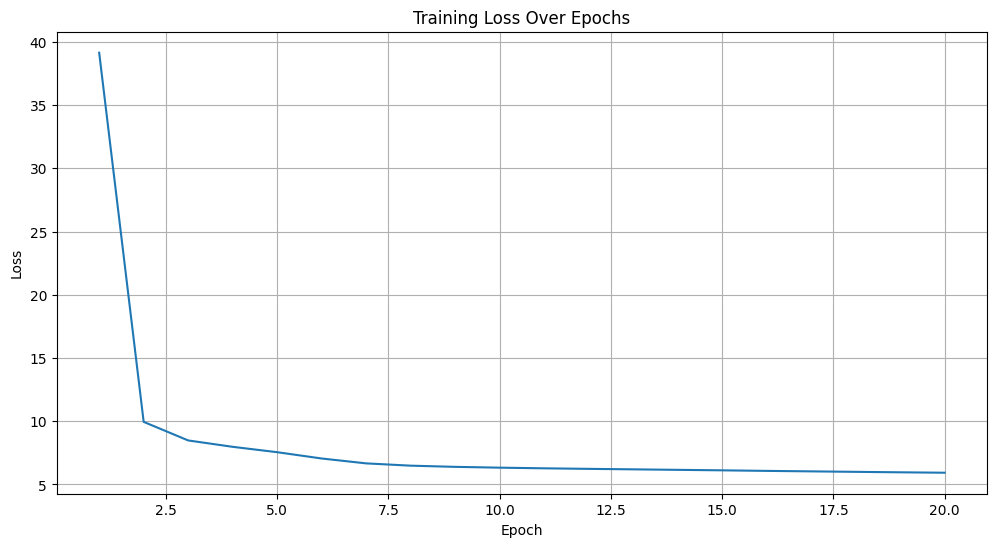

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


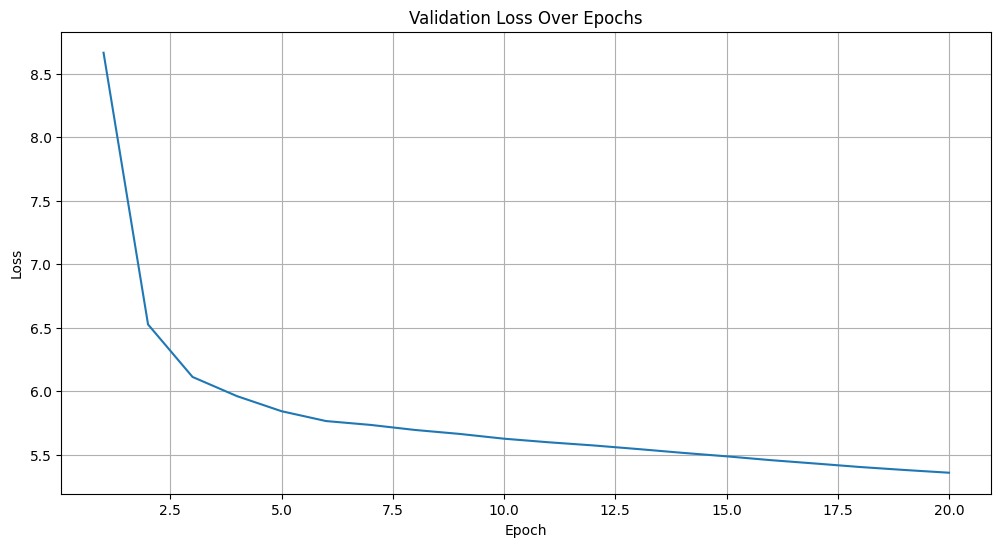

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


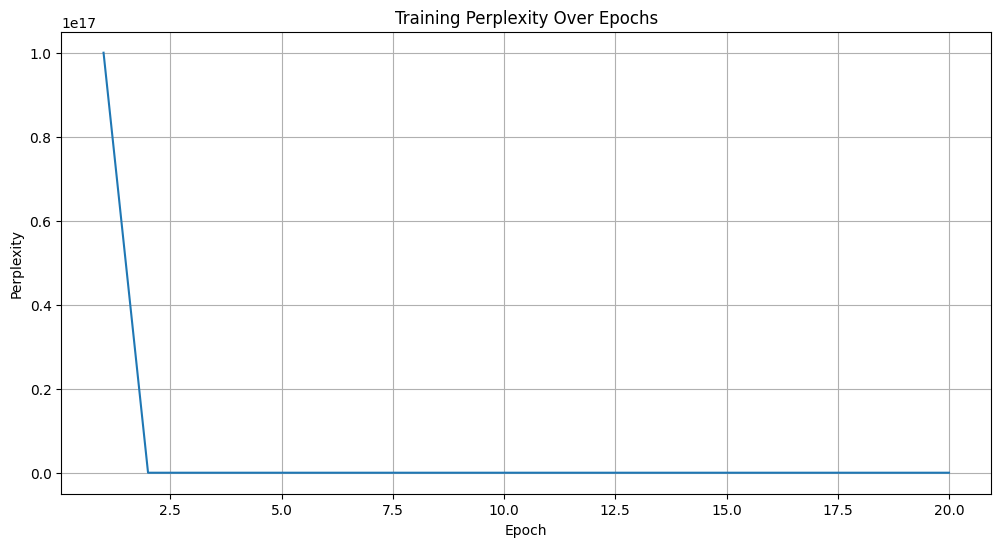

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Perplexity")
plt.title("Training Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


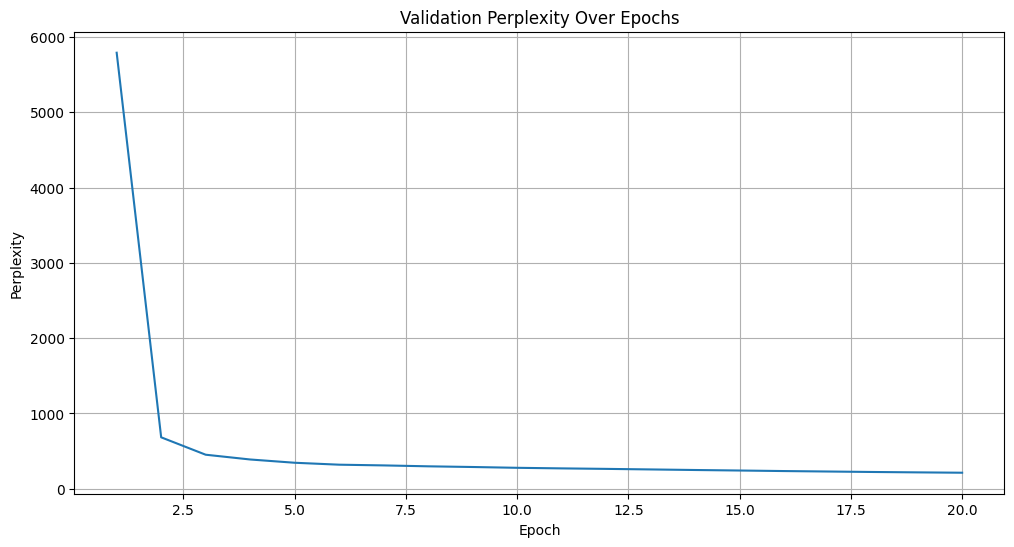

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Perplexity")
plt.title("Validation Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

We can see that our most model would be at 10 epochs. We should use early stopping here.

## Testing

In [23]:
torch.save(model.state_dict(), "model_wgts/model_weights_q2.pth")

In [25]:
saved_model = get_model(
    vocab_size, d_model=512, N=7, heads=8, dropout=0.1, device=DEVICE
)

In [26]:
saved_model.load_state_dict(
    torch.load("model_wgts/model_weights_q2.pth", map_location=DEVICE)
)

<All keys matched successfully>

In [27]:
test_tokens = load_and_tokenize_file("data/wiki2.test.txt", TOKENIZER)
test_batch_generator = BatchGenerator(
    train_tokens, seq_len=512, batch_size=25, pad_token_id=TOKENIZER.pad_token_id
)

In [28]:
def test_model(model, generator, device):
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(generator.generate()):
            batch_tensor = torch.tensor(batch).to(device)
            no_peak_mask = nopeak_mask(batch_tensor.size(1), device)

            preds = model(batch_tensor, no_peak_mask)
            preds = preds[:, :-1, :]
            ys = batch_tensor[:, 1:].contiguous().view(-1)

            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            total_test_loss += loss.item()

            if (i + 1) == generator.steps_per_epoch:
                break

    avg_test_loss = total_test_loss / generator.steps_per_epoch
    test_perplexity = torch.exp(torch.tensor(avg_test_loss)).item()

    return avg_test_loss, test_perplexity

In [29]:
loss, perplexity = test_model(saved_model, test_batch_generator, DEVICE)

In [30]:
print("Average Loss:", loss)

Average Loss: 5.814934415121873


In [31]:
print("Perplexity:", perplexity)

Perplexity: 335.26934814453125
